In [60]:
import psycopg2
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import coordinates
from astropy.time import Time
from datetime import datetime


from IPython.display import HTML
from ipywidgets import Layout, Box, widgets
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import viridis
from alerce.core import Alerce

In [61]:
client = Alerce()

In [62]:
import requests
url = "https://raw.githubusercontent.com/alercebroker/usecases/master/alercereaduser_v4.json"
params = requests.get(url).json()['params']

In [63]:
conn = psycopg2.connect(dbname=params['dbname'], user=params['user'], host=params['host'], password=params['password'])

In [64]:
mjd_first = Time("2021-03-01T00:00:00", scale='utc').mjd
mjd_last = Time("2021-04-01T00:00:00", scale='utc').mjd

query='''
SELECT
object.oid, object.meanra, object.meandec, object.firstmjd,
object.ndet, probability.probability

FROM object
INNER JOIN probability
ON object.oid=probability.oid

WHERE 
object.firstMJD>%s
AND object.firstMJD<%s
AND object.ndet=1
AND probability.classifier_name='stamp_classifier'
AND probability.class_name='asteroid'
AND probability.probability>0.7
''' % (mjd_first, mjd_last)

ast = pd.read_sql_query(query, conn)
ast.set_index('oid', inplace=True)
print(ast.shape)
ast.head()

c:\Users\esteban ez\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


(106895, 5)


,meanra,meandec,firstmjd,ndet,probability
oid,,,,,
ZTF21aanqpwg,156.660014,10.679691,59274.212454,1,0.700072
ZTF21aanqjqc,84.403597,10.469394,59274.147813,1,0.725208
ZTF21aanqpxc,157.088644,15.424231,59274.212454,1,0.728637
ZTF21aanqpyv,154.226348,12.072717,59274.212454,1,0.710321
ZTF21aanqpzu,156.451785,14.969416,59274.212454,1,0.705238


In [65]:
query='''
SELECT *
FROM ss_ztf
WHERE 
oid in (%s)
AND ssdistnr >= 0
AND ssdistnr <= 5.0
ORDER BY oid
''' % ",".join(["'%s'" % oid for oid in ast.index])

ss = pd.read_sql_query(query, conn)
print(ss.shape)
ss.head()

c:\Users\esteban ez\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


(106387, 5)


,oid,candid,ssdistnr,ssmagnr,ssnamenr
0,ZTF18aaavzci,1549155913415015015,0.0,19.9,77314
1,ZTF18aaaxbqb,1549153564115015003,1.0,19.5,36263
2,ZTF18aaaxbuo,1547212622015015006,0.0,18.1,13289
3,ZTF18aabqfyb,1550307190015015012,0.0,19.8,349197
4,ZTF18aabwrag,1549239930415015008,0.0,20.0,175315


In [66]:
ndet = ss.groupby("ssnamenr").apply(lambda df: df.shape[0])

In [67]:
ndetmin = 10
X = []
Y = []
Z = []
Q = []
P = []
OID = []
CND = []
for ssnamenr in ndet.loc[ndet>=ndetmin].index:
  query='''
  SELECT *
  FROM ss_ztf
  WHERE 
  ssnamenr = '%s'
  ''' % ssnamenr

  selast = pd.read_sql_query(query, conn)
  selast.set_index("candid", inplace=True)
  query='''
  SELECT candid, mjd, fid, magpsf, sigmapsf, oid
  FROM detection
  WHERE 
  candid in (%s)
  ''' % ",".join(["'%s'" % candid for candid in selast.index])

  selast_lc = pd.read_sql_query(query, conn)
  selast_lc.set_index("candid", inplace=True)
  for fid in selast_lc.fid.unique():
    mask = (selast_lc.fid == fid)

    if len(selast_lc.loc[mask].mjd) > 1 and len(selast_lc.loc[mask].mjd)==len(selast_lc.loc[mask].magpsf) and len(selast_lc.fid.unique())==2: 
      X.append(np.array(selast_lc.loc[mask].mjd).tolist())
      Y.append(np.array(selast_lc.loc[mask].magpsf).tolist())
      Z.append(np.array(selast.loc[selast_lc.index].ssmagnr).tolist())
      P.append(np.array(selast_lc.loc[mask].magpsf - selast.loc[selast_lc.loc[mask].index].ssmagnr).tolist())
      Q.append(np.array(selast_lc.mjd).tolist())
      OID.append(np.array(selast_lc.oid).tolist())
      CND.append(np.array(selast_lc.index).tolist())
      


c:\Users\esteban ez\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
c:\Users\esteban ez\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
c:\Users\esteban ez\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
c:\Users\esteban ez\AppData\Local\Programs\Python\Python310\lib\

In [68]:

print(len(CND[1]))

80


In [69]:
print(len(P))
print(len(OID))


180
180


In [70]:

Xt = X
Yt = Y
Zt = Z
Qt = Q
Pt = P
Ot = OID
Ct = CND
i=0
while i< len(Xt):

    if len(Xt[i][:150])<150:
        k = len(Xt[i])
        while k < 150:
            Xt[i].append((Xt[i][len(Xt[i])-1]))
            k = k+1    
    else:
        Xt[i]=(Xt[i][:150])
        i=i+1

i=0
while i< len(Yt):
    if len(Yt[i][:150])<150:
        k = len(Yt[i])
        while k < 150:
            Yt[i].append((Yt[i][len(Yt[i])-1]))
            k= k+1
    else:
        Yt[i]=(Yt[i][:150])
    i=i+1

i=0
while i< len(Zt):
    if len(Zt[i][:150])<150:
        k = len(Zt[i])
        while k < 150:
            Zt[i].append((Zt[i][len(Zt[i])-1]))
            k= k+1
    else:
        Zt[i]=(Zt[i][:150])
    i=i+1

i=0
while i< len(Qt):
    if len(Qt[i][:150])<150:
        k = len(Qt[i])
        while k < 150:
            Qt[i].append((Qt[i][len(Qt[i])-1]))
            k= k+1
    else:
        Qt[i]=(Qt[i][:150])
    i=i+1

i=0
while i< len(Pt):
    if len(Pt[i][:150])<150:
        k = len(Pt[i])
        while k < 150:
            Pt[i].append((Pt[i][len(Pt[i])-1]))
            k= k+1
    else:
        Pt[i]=(Pt[i][:150])
    i=i+1

i=0
while i< len(Ot):
    if len(Ot[i][:150])<150:
        k = len(Ot[i])
        while k < 150:
            Ot[i].append((Ot[i][len(Ot[i])-1]))
            k= k+1
    else:
        Ot[i]=(Ot[i][:150])
    i=i+1

i=0
while i< len(Ct):
    if len(Ct[i][:150])<150:
        k = len(Ct[i])
        while k < 150:
            Ct[i].append((Ct[i][len(Ct[i])-1]))
            k= k+1
    else:
        Ct[i]=(Ct[i][:150])
    i=i+1


In [71]:
j=0
Xt2 = Xt
Yt2 = Yt
Zt2 = Zt
Qt2 = Qt 
Pt2 = Pt
Ot2 =Ot
Ct2 =Ct
while j < len(X):
    Xt2[j]=np.array(Xt[j])
    Yt2[j]=np.array(Yt[j])
    Zt2[j]=np.array(Zt[j])
    Qt2[j]=np.array(Qt[j])
    Pt2[j]=np.array(Pt[j])
    Ot2[j]=np.array(Ot[j]) 
    Ct2[j]=np.array(Ct[j]) 
    j=j+1
Xt2 = np.array(Xt2)
Yt2 = np.array(Yt2)
Zt2 = np.array(Zt2)
Qt2 = np.array(Qt2)
Pt2 = np.array(Pt2)
Ot2 = np.array(Ot2)
Ct2 = np.array(Ct2)

In [72]:
j=0
Xt3 = []
Yt3 = []
Zt3 = []
Qt3 = [] 
Pt3 = []
Ot3 = []
Ct3 = []
while j < len(Yt)/2:
    Xt3.append(np.concatenate((Xt2[2*j], Xt2[2*j + 1] )))
    Yt3.append(np.concatenate((Yt2[2*j], Yt2[2*j + 1] )))
    Zt3.append( np.concatenate((Zt2[2*j], Zt2[2*j + 1])))
    Qt3.append(np.concatenate((Qt2[2*j], Qt2[2*j + 1] )))
    Pt3.append(np.concatenate((Pt2[2*j], Pt2[2*j + 1] )))
    Ot3.append(np.concatenate((Ot2[2*j], Ot2[2*j + 1] )))
    Ct3.append(np.concatenate((Ct2[2*j], Ct2[2*j + 1] )))
    
    j=j+1
Xt3 = np.array(Xt3)
Yt3 = np.array(Yt3)
Zt3 = np.array(Zt3)
Qt3 = np.array(Qt3)
Pt3 = np.array(Pt3)
Ot3 = np.array(Ot3)
Ct3 = np.array(Ct3)

In [73]:
j=0
M = []
M2 = []
M3 = []
M3L = Ot3
M3L2 = Ct3
M4 = []
while j < len(Yt3):
    M.append(np.concatenate((Xt3[j], Yt3[j])))
    M2.append(np.concatenate((np.concatenate((Xt3[j], Yt3[j])),np.concatenate((Zt3[j], Qt3[j])))))
    M3.append(np.concatenate((Xt3[j], Pt3[j])))
    j=j+1
M = np.array(M)
M2 = np.array(M2)
M3 = np.array(M3)

In [74]:
np.shape(M3L2)

(90, 300)

In [75]:
df = pd.DataFrame(M)
df2 = pd.DataFrame(M2)
df3 = pd.DataFrame(M3)

Text(0.5, 1.0, 'UMAP projection of Asteroid Data')

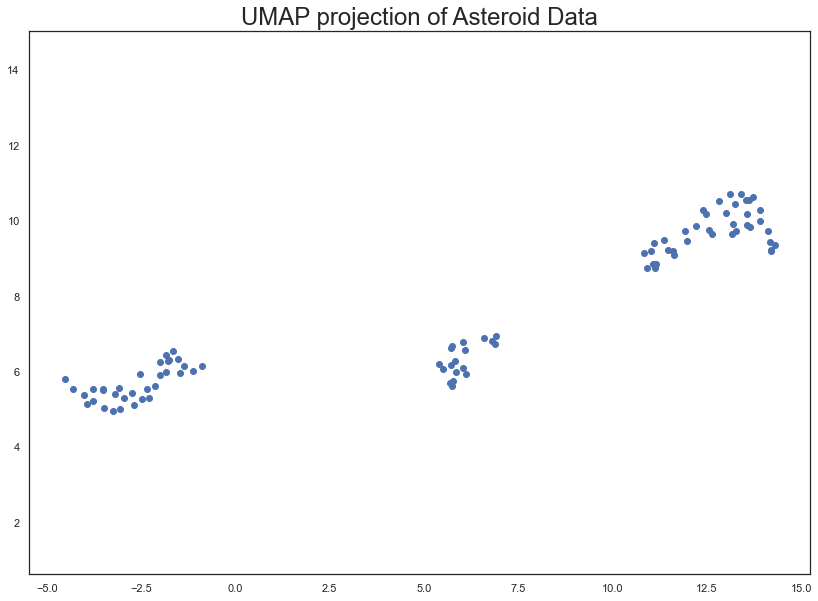

In [76]:
import umap 
from sklearn.preprocessing import StandardScaler
reducer3 = umap.UMAP(random_state= 2)
scaled_ff3 = StandardScaler().fit_transform(df3)
embedding3 = reducer3.fit_transform(scaled_ff3)
plt.scatter(embedding3[:, 0],embedding3[:, 1]) 
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of Asteroid Data', fontsize=24)

In [77]:
XfM3 = df3
YfM3 = df3.index.tolist()

In [78]:
from sklearn.cluster import KMeans
model3 = KMeans(n_clusters=3)
model3.fit(embedding3)
centers3 = model3.cluster_centers_
labels3 = model3.labels_

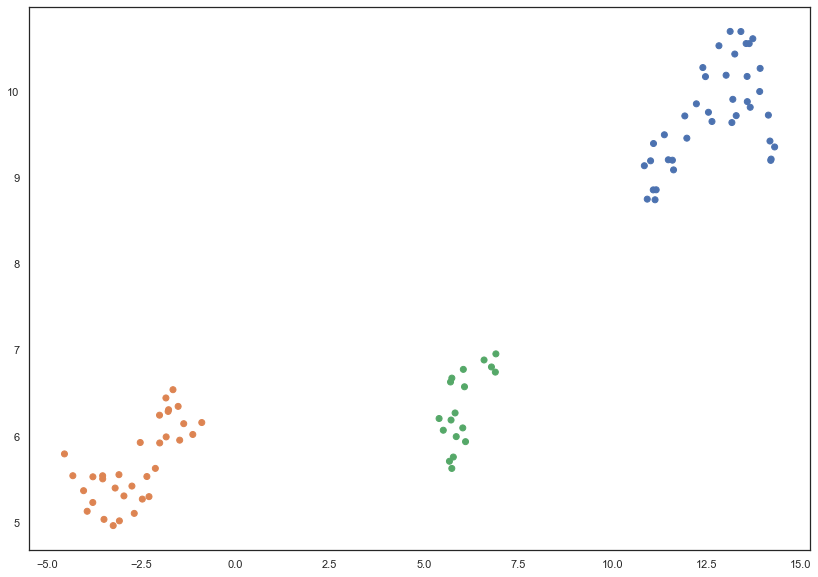

In [79]:

import seaborn as sns

sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
plt.scatter(
    embedding3[:, 0],
    embedding3[:, 1],
    c=[sns.color_palette()[x] for x in labels3])

In [80]:
XM3f0 = []
XM3f1 = []
XM3f2 = []

XffM3 = np.array(XfM3).tolist()

i=0
while i < len(labels3):
    if labels3[i] == 0:
        XM3f0.append(XffM3[i])
    elif labels3[i] == 1:
        XM3f1.append(XffM3[i])
    elif labels3[i] == 2:
        XM3f2.append(XffM3[i])
    i=i+1

In [81]:
print(np.shape(Ot3))
print(Ot3[1][8])

(90, 300)
ZTF19abxoiec


In [82]:
print(len(labels3))

90


In [83]:
OIDs0 = []
OIDs1 = []
OIDs2 = []
OIDSM3 = np.array(XfM3).tolist()
i=0
while i < len(labels3):
    if labels3[i] == 0:
        j=0
        while j < len(Ot3[i]):
            OIDs0.append(Ot3[i][j])
            j=j+1
    elif labels3[i] == 1:
        j=0
        while j < len(Ot3[i]):
            OIDs1.append(Ot3[i][j])
            j=j+1
    elif labels3[i] == 2:
        j=0
        while j < len(Ot3[i]):
            OIDs2.append(Ot3[i][j])
            j=j+1
    i=i+1

In [84]:
Cans0 = []
Cans1 = []
Cans2 = []
CansM3 = np.array(XfM3).tolist()
i=0
while i < len(labels3):
    if labels3[i] == 0:
        j=0
        while j < len(Ct3[i]):
            Cans0.append(Ct3[i][j])
            j=j+1
    elif labels3[i] == 1:
        j=0
        while j < len(Ct3[i]):
            Cans1.append(Ct3[i][j])
            j=j+1
    elif labels3[i] == 2:
        j=0
        while j < len(Ct3[i]):
            Cans2.append(Ct3[i][j])
            j=j+1
    i=i+1

In [85]:
print(np.shape(Ct3))
print(len(Cans0)/300)
print(len(Cans1)/300)
print(len(Cans2)/300)


(90, 300)
39.0
33.0
18.0


In [86]:
Stamps = []
i=0
while i<len(Cans0):
    if OIDs0[i] != OIDs0[i-30] and Cans0[i] != Cans0[i-30]:
        Stamps.append(client.get_stamps(oid = OIDs0[i], candid= Cans0[i]))
    i=i+30

In [87]:
print(len(Stamps))

386


In [88]:
import io, gzip
from astropy.io import fits
def get_image_from_bytes_stamp(stamp_byte):
  with gzip.open(io.BytesIO(stamp_byte), 'rb') as f:
    with fits.open(io.BytesIO(f.read()), ignore_missing_simple=True) as hdul:
      img = hdul[0].data
  return img

In [89]:
Stamps1 =[]
i=0
while i < len(Stamps):
    Stamps1.append([])
    Stamps1[i].append([])
    Stamps1[i].append([])
    Stamps1[i].append([])
    Stamps1[i][0] = Stamps[i][0].data
    Stamps1[i][1] = Stamps[i][1].data
    Stamps1[i][2] = Stamps[i][2].data
    i=i+1

In [90]:
print(Stamps1[0][0][0][0])

330.23065


In [91]:
Stamps2 = np.zeros((len(Stamps1), 3))
i=0
while i <= len(Stamps1)-1:
  Stamps2[i][0]= np.nanmedian(Stamps1[i][0])
  Stamps2[i][1]= np.nanmedian(Stamps1[i][1])
  Stamps2[i][2]= np.nanmedian(Stamps1[i][2])
  i=i+1

In [92]:
Stamps3 = np.zeros((len(Stamps1), 3, 21, 21))
z=0
i=0
while i <= len(Stamps1)-1:
  j=0
  while j <= 20:
    k=0
    while k<= 20:
      Stamps3[i][0][j][k] = Stamps1[i][0][j][k]
      Stamps3[i][1][j][k] = Stamps1[i][1][j][k]
      Stamps3[i][2][j][k] = Stamps1[i][2][j][k]
      if np.isnan(Stamps3[i][0][j][k]) == True:
        Stamps3[i][0][j][k] = Stamps2[i][0]
        z=z+1

      if np.isnan(Stamps3[i][1][j][k]) == True:
        Stamps3[i][1][j][k] = Stamps2[i][1]
        z=z+1
      if np.isnan(Stamps3[i][2][j][k]) == True:
        Stamps3[i][2][j][k] = Stamps2[i][2]
        z=z+1
      k= k+1
    j=j+1
  i=i+1

In [93]:

from sklearn.preprocessing import normalize
Stamps4 = np.zeros((len(Stamps3), 3, 21, 21))
i=0
while i <= len(Stamps3)-1:
  Stamps4[i][0]= normalize(Stamps3[i][0])
  Stamps4[i][1]= normalize(Stamps3[i][1])
  Stamps4[i][2]= normalize(Stamps3[i][2])
  i=i+1


'\nfrom sklearn.preprocessing import normalize\nStamps4 = np.zeros((len(Stamps3), 3, 21, 21))\ni=0\nwhile i <= len(Stamps3)-1:\n  Stamps4[i][0]= normalize(Stamps3[i][0])\n  Stamps4[i][1]= normalize(Stamps3[i][1])\n  Stamps4[i][2]= normalize(Stamps3[i][2])\n  i=i+1\n'

In [94]:
StampsF = np.zeros((len(Stamps3), 21, 21, 3))
z=0
i=0
while i <len(Stamps4):
  j=0
  while j <= 20:
    k=0
    while k<= 20:
      StampsF[i][j][k][0] = Stamps4[i][0][j][k]
      StampsF[i][j][k][1] = Stamps4[i][1][j][k]
      StampsF[i][j][k][2] = Stamps4[i][2][j][k]
      k= k+1
    j=j+1
  i=i+1

In [95]:
StampsC1 = []
i=0
while i<len(Cans1):
    if OIDs1[i] != OIDs1[i-30] and Cans1[i] != Cans1[i-30]:
        StampsC1.append(client.get_stamps(oid = OIDs1[i], candid= Cans1[i]))
    i=i+30

In [96]:
StampsC11 =[]
i=0
while i < len(StampsC1):
    StampsC11.append([])
    StampsC11[i].append([])
    StampsC11[i].append([])
    StampsC11[i].append([])
    StampsC11[i][0] = StampsC1[i][0].data
    StampsC11[i][1] = StampsC1[i][1].data
    StampsC11[i][2] = StampsC1[i][2].data
    i=i+1

In [97]:
StampsC12 = np.zeros((len(StampsC11), 3))
i=0
while i <= len(StampsC11)-1:
  StampsC12[i][0]= np.nanmedian(StampsC11[i][0])
  StampsC12[i][1]= np.nanmedian(StampsC11[i][1])
  StampsC12[i][2]= np.nanmedian(StampsC11[i][2])
  i=i+1

In [98]:
StampsC13 = np.zeros((len(StampsC11), 3, 21, 21))
z=0
i=0
while i <= len(StampsC11)-1:
  j=0
  while j <= 20:
    k=0
    while k<= 20:
      StampsC13[i][0][j][k] = StampsC11[i][0][j][k]
      StampsC13[i][1][j][k] = StampsC11[i][1][j][k]
      StampsC13[i][2][j][k] = StampsC11[i][2][j][k]
      if np.isnan(StampsC13[i][0][j][k]) == True:
        StampsC13[i][0][j][k] = StampsC12[i][0]
        z=z+1

      if np.isnan(StampsC13[i][1][j][k]) == True:
        StampsC13[i][1][j][k] = StampsC12[i][1]
        z=z+1
      if np.isnan(StampsC13[i][2][j][k]) == True:
        StampsC13[i][2][j][k] = StampsC12[i][2]
        z=z+1
      k= k+1
    j=j+1
  i=i+1

In [99]:

from sklearn.preprocessing import normalize
StampsC14 = np.zeros((len(StampsC13), 3, 21, 21))
i=0
while i <= len(StampsC13)-1:
  StampsC14[i][0]= normalize(StampsC13[i][0])
  StampsC14[i][1]= normalize(StampsC13[i][1])
  StampsC14[i][2]= normalize(StampsC13[i][2])
  i=i+1


'\nfrom sklearn.preprocessing import normalize\nStampsC14 = np.zeros((len(StampsC13), 3, 21, 21))\ni=0\nwhile i <= len(StampsC13)-1:\n  StampsC14[i][0]= normalize(StampsC13[i][0])\n  StampsC14[i][1]= normalize(StampsC13[i][1])\n  StampsC14[i][2]= normalize(StampsC13[i][2])\n  i=i+1\n'

In [100]:
StampsC1F = np.zeros((len(StampsC13), 21, 21, 3))
z=0
i=0
while i <len(StampsC14):
  j=0
  while j <= 20:
    k=0
    while k<= 20:
      StampsC1F[i][j][k][0] = StampsC14[i][0][j][k]
      StampsC1F[i][j][k][1] = StampsC14[i][1][j][k]
      StampsC1F[i][j][k][2] = StampsC14[i][2][j][k]
      k= k+1
    j=j+1
  i=i+1

In [101]:
StampsC2 = []
i=0
while i<len(Cans2):
    if OIDs2[i] != OIDs2[i-30] and Cans2[i] != Cans2[i-30]:
        StampsC2.append(client.get_stamps(oid = OIDs2[i], candid= Cans2[i]))
    i=i+30

In [102]:
StampsC21 =[]
i=0
while i < len(StampsC2):
    StampsC21.append([])
    StampsC21[i].append([])
    StampsC21[i].append([])
    StampsC21[i].append([])
    StampsC21[i][0] = StampsC2[i][0].data
    StampsC21[i][1] = StampsC2[i][1].data
    StampsC21[i][2] = StampsC2[i][2].data
    i=i+1

In [103]:
StampsC22 = np.zeros((len(StampsC21), 3))
i=0
while i <= len(StampsC21)-1:
  StampsC22[i][0]= np.nanmedian(StampsC21[i][0])
  StampsC22[i][1]= np.nanmedian(StampsC21[i][1])
  StampsC22[i][2]= np.nanmedian(StampsC21[i][2])
  i=i+1

In [104]:
StampsC23 = np.zeros((len(StampsC21), 3, 21, 21))
z=0
i=0
while i <= len(StampsC21)-1:
  j=0
  while j <= 20:
    k=0
    while k<= 20:
      StampsC23[i][0][j][k] = StampsC21[i][0][j][k]
      StampsC23[i][1][j][k] = StampsC21[i][1][j][k]
      StampsC23[i][2][j][k] = StampsC21[i][2][j][k]
      if np.isnan(StampsC23[i][0][j][k]) == True:
        StampsC23[i][0][j][k] = StampsC22[i][0]
        z=z+1

      if np.isnan(StampsC23[i][1][j][k]) == True:
        StampsC23[i][1][j][k] = StampsC22[i][1]
        z=z+1
      if np.isnan(StampsC23[i][2][j][k]) == True:
        StampsC23[i][2][j][k] = StampsC22[i][2]
        z=z+1
      k= k+1
    j=j+1
  i=i+1

In [105]:

from sklearn.preprocessing import normalize
StampsC24 = np.zeros((len(StampsC23), 3, 21, 21))
i=0
while i <= len(StampsC23)-1:
  StampsC24[i][0]= normalize(StampsC23[i][0])
  StampsC24[i][1]= normalize(StampsC23[i][1])
  StampsC24[i][2]= normalize(StampsC23[i][2])
  i=i+1


'\nfrom sklearn.preprocessing import normalize\nStampsC24 = np.zeros((len(StampsC23), 3, 21, 21))\ni=0\nwhile i <= len(StampsC23)-1:\n  StampsC24[i][0]= normalize(StampsC23[i][0])\n  StampsC24[i][1]= normalize(StampsC23[i][1])\n  StampsC24[i][2]= normalize(StampsC23[i][2])\n  i=i+1\n'

In [106]:
StampsC2F = np.zeros((len(StampsC23), 21, 21, 3))
z=0
i=0
while i <len(StampsC24):
  j=0
  while j <= 20:
    k=0
    while k<= 20:
      StampsC2F[i][j][k][0] = StampsC24[i][0][j][k]
      StampsC2F[i][j][k][1] = StampsC24[i][1][j][k]
      StampsC2F[i][j][k][2] = StampsC24[i][2][j][k]
      k= k+1
    j=j+1
  i=i+1

In [107]:
print(np.shape(StampsF))
print(np.shape(StampsC1F))
print(np.shape(StampsC2F))

(386, 21, 21, 3)
(326, 21, 21, 3)
(168, 21, 21, 3)


In [108]:
Labels = []
Data = []
i=0
while i < len(StampsF):
    Labels.append(0)
    Data.append(StampsF[i])
    i=i+1
i=0
while i < len(StampsC1F):
    Labels.append(1)
    Data.append(StampsC1F[i])
    i=i+1
i=0
while i < len(StampsC2F):
    Labels.append(2)
    Data.append(StampsC2F[i])
    i=i+1
Data2 = np.array(Data)

In [109]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
dff= Data2
Y= Labels
Y2 = np.array(Y)
Y3= Y2.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(Data2, Y3, test_size=0.3, random_state=1)

In [110]:

unique, counts = np.unique(Y2, return_counts=True)
dict(zip(unique, counts/2))

{0: 193.0, 1: 163.0, 2: 84.0}

In [111]:

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import os
tf.__version__
model5 = models.Sequential()
model5.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(21, 21, 3)))
model5.add(layers.MaxPooling2D((2, 2)))
model5.add(layers.Conv2D(64, (3, 3), activation='relu'))
model5.add(layers.MaxPooling2D((2, 2)))
model5.add(layers.Conv2D(64, (3, 3), activation='relu'))

model5.add(layers.Flatten())
model5.add(layers.Dense(64, activation='relu'))
model5.add(layers.Dense(10))

In [112]:
%reload_ext tensorboard
model5.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
log_dir3 = "logs3/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir3, histogram_freq=1)
history = model5.fit(X_train, y_train, epochs=12, 
                    validation_data=(X_train, y_train),
                    callbacks=[tensorboard_callback])

Epoch 1/12
20/20 [==============================] - 3s 91ms/step - loss: nan - accuracy: 0.3945 - val_loss: nan - val_accuracy: 0.4448
Epoch 2/12
20/20 [==============================] - 1s 33ms/step - loss: nan - accuracy: 0.4448 - val_loss: nan - val_accuracy: 0.4448
Epoch 3/12
20/20 [==============================] - 1s 56ms/step - loss: nan - accuracy: 0.4448 - val_loss: nan - val_accuracy: 0.4448
Epoch 4/12
20/20 [==============================] - 1s 35ms/step - loss: nan - accuracy: 0.4448 - val_loss: nan - val_accuracy: 0.4448
Epoch 5/12
20/20 [==============================] - 1s 32ms/step - loss: nan - accuracy: 0.4448 - val_loss: nan - val_accuracy: 0.4448
Epoch 6/12
20/20 [==============================] - 1s 47ms/step - loss: nan - accuracy: 0.4448 - val_loss: nan - val_accuracy: 0.4448
Epoch 7/12
20/20 [==============================] - 1s 31ms/step - loss: nan - accuracy: 0.4448 - val_loss: nan - val_accuracy: 0.4448
Epoch 8/12
20/20 [==============================] - 1s 

In [113]:
%tensorboard --logdir logs3/fit

Reusing TensorBoard on port 6006 (pid 4332), started 4:41:30 ago. (Use '!kill 4332' to kill it.)

In [114]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

9/9 [==============================] - 0s 6ms/step
Confusion matrix, without normalization


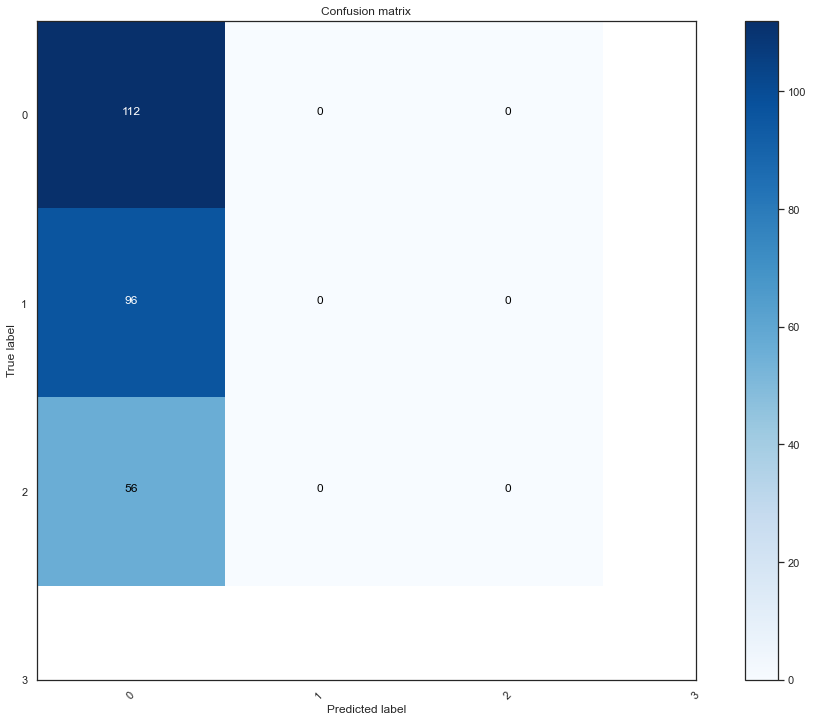

In [115]:
predictions = model5.predict(X_test)
plot_confusion_matrix(confusion_matrix(y_test, np.argmax(predictions, axis=1)), range(4))

In [116]:
predictions2 = np.argmax(predictions, axis=1)
Y_real = []
WX = []

i=0
while i <= len(predictions2)-1:
  if predictions2[i] == y_test[i]:
    WX.append(X_test[i])
    Y_real.append(y_test[i])
  i=i+1

In [117]:
L0 = []
L1 = []
L2 = []

j=0
while j <= len(WX)-1:
  if Y_real[j] == 0:
    L0.append(WX[j])
  elif Y_real[j] == 1:
    L1.append(WX[j])
  elif Y_real[j] == 2:
    L2.append(WX[j])
  j=j+1

In [118]:
import random as rd
Xf1= rd.sample(L1, 2)
Xf2= rd.sample(L2, 2)

ValueError: Sample larger than population or is negative

NameError: name 'Xf0' is not defined

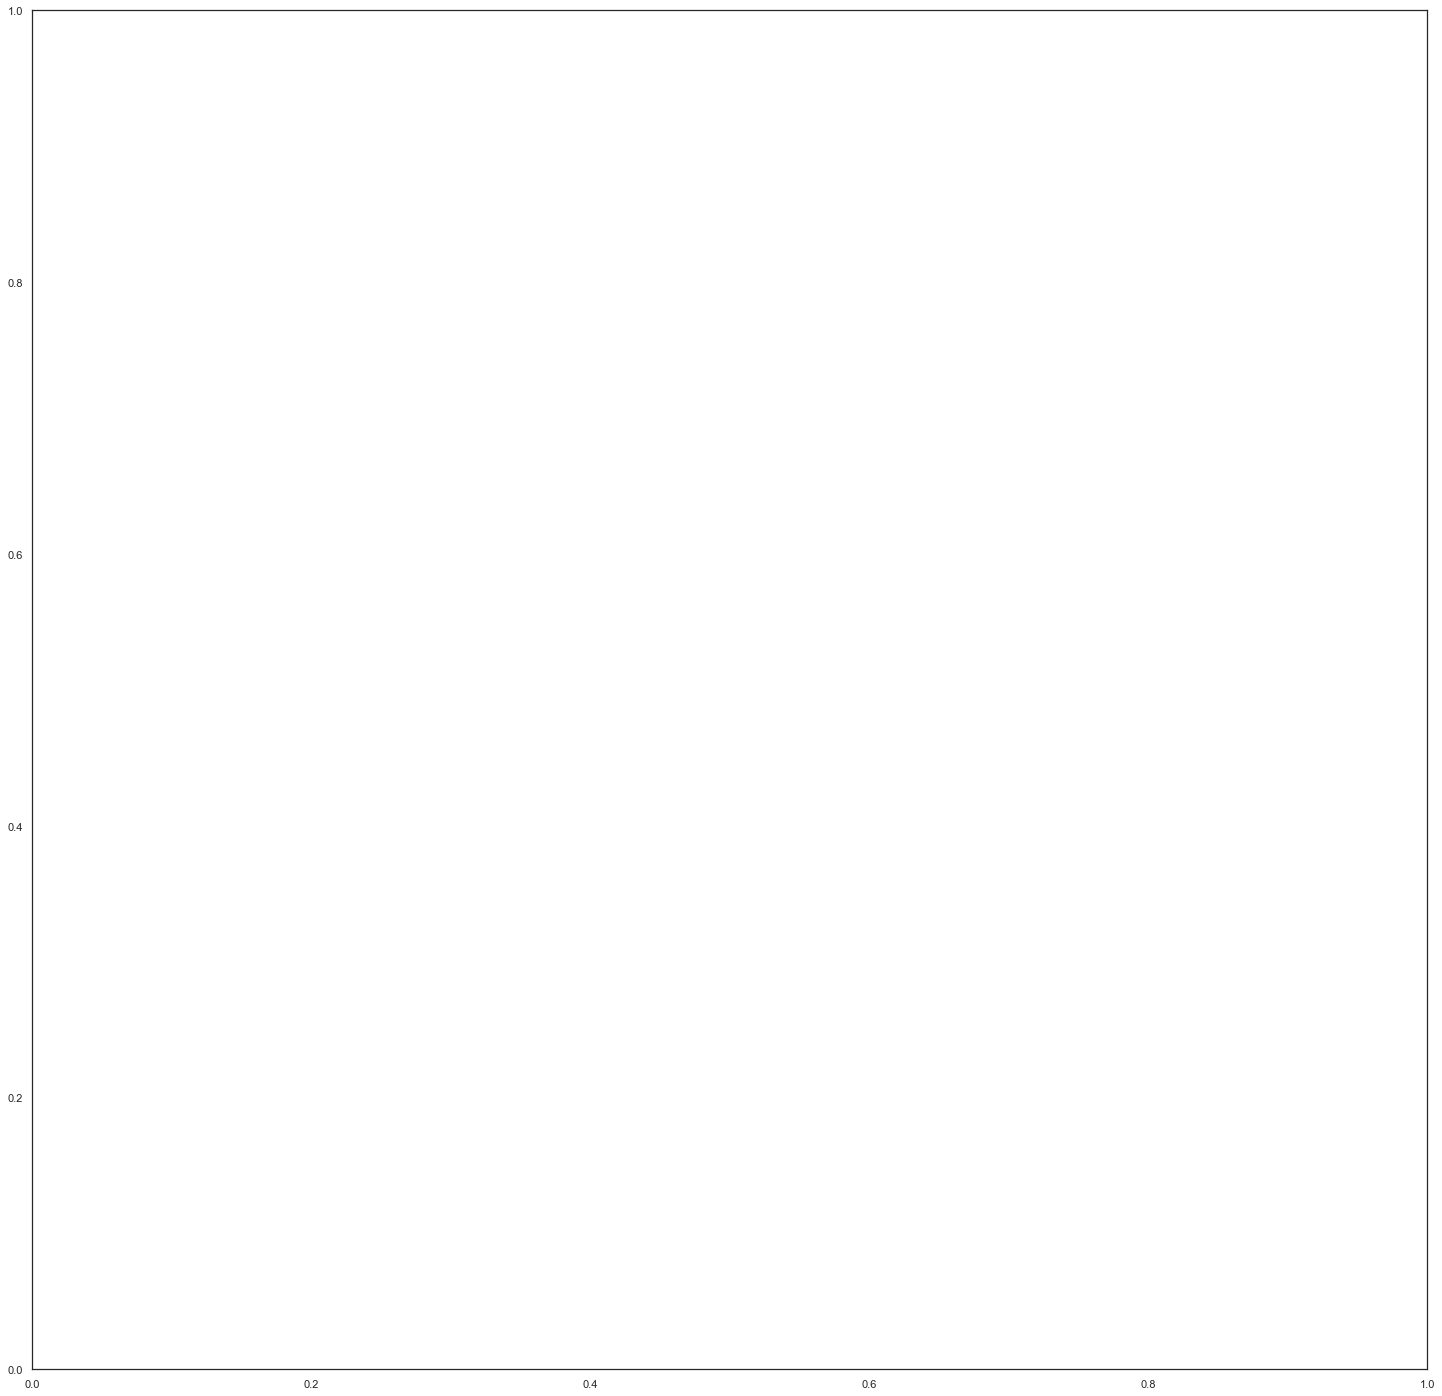

In [ ]:
plt.subplots(figsize=(25, 25))
j=0
while j <= len(Xf0)-1:
  plt.subplot(5, 2, j+1)
  plt.title(str('0') + ' ' + str('Bien clasificadas'))
  plt.imshow(Xf0[j])
  j=j+1
plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

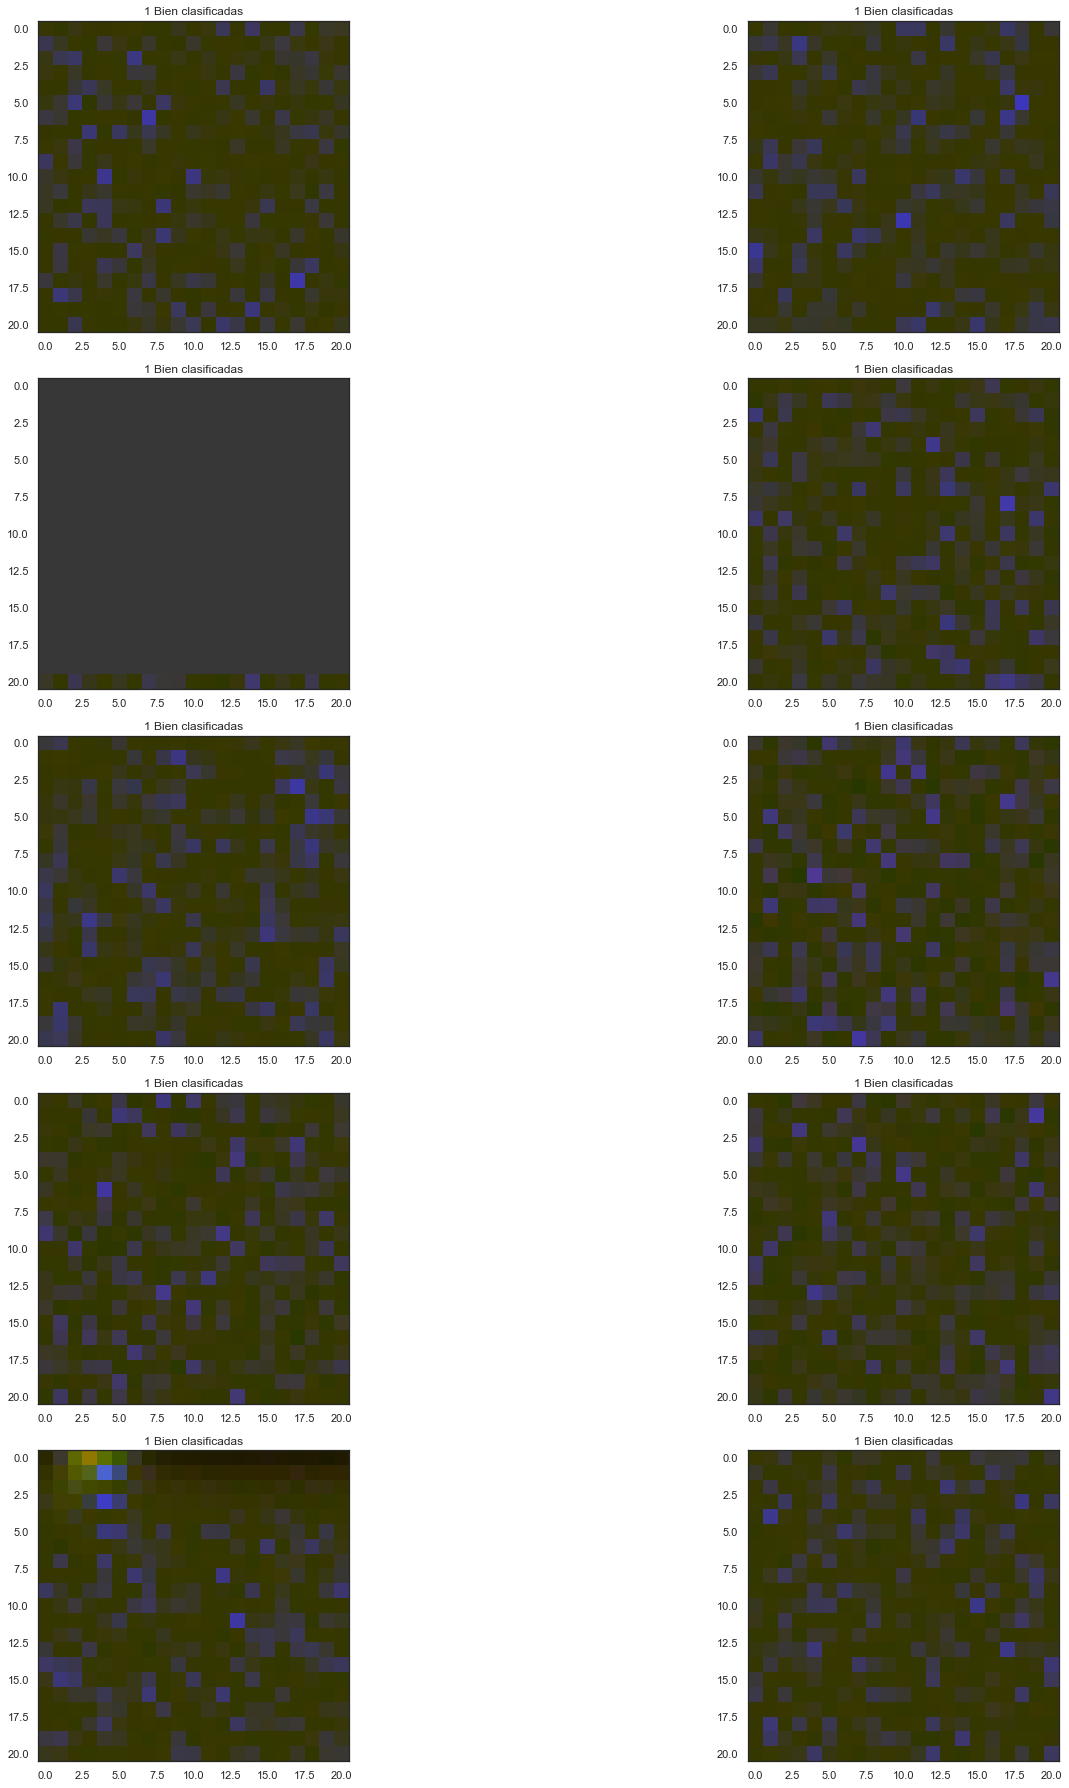

In [ ]:
plt.subplots(figsize=(25, 25))
j=0
while j <= len(Xf1)-1:
  plt.subplot(5, 2, j+1)
  plt.title(str('1') + ' ' + str('Bien clasificadas'))
  plt.imshow(Xf1[j])
  j=j+1
plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


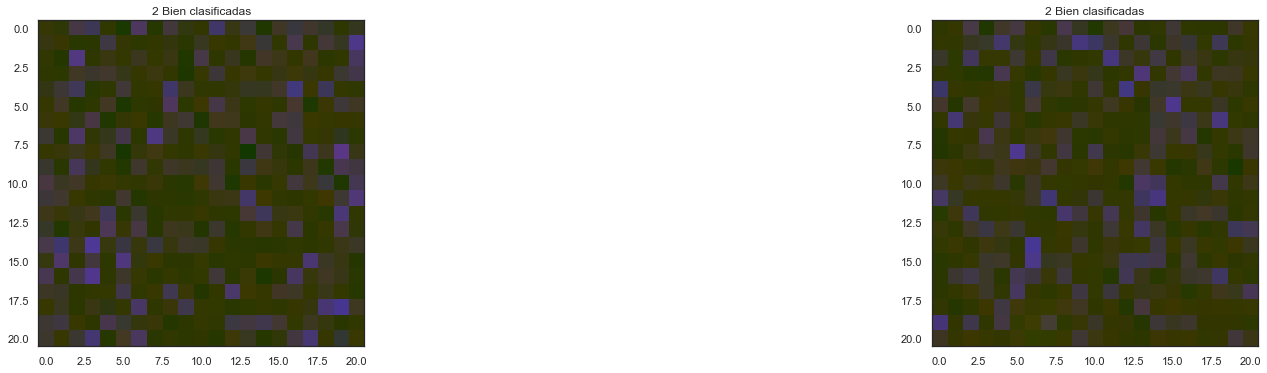

In [ ]:
plt.subplots(figsize=(25, 25))
j=0
while j <= len(Xf2)-1:
  plt.subplot(5, 2, j+1)
  plt.title(str('2') + ' ' + str('Bien clasificadas'))
  plt.imshow(Xf2[j])
  j=j+1
plt.tight_layout()